In [1]:
# Load libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import binom

In [2]:
# Define helpers.

# Parse series to integer.
def parse_integer(series):
    return pd.to_numeric(series, errors='coerce').astype('Int64')

# Recursive helper: P(Y_i <= U_i for all i), Y ~ Multinomial(n, q)
def upper_leq_mult(n, q, U):
    K = len(q)
    if U.sum() < n:
        return 0.0
    if K == 1:
        return float(n <= U[0])
    q1 = q[0]
    U1 = int(U[0])
    lo = max(0, n - int(U[1:].sum()))
    hi = min(U1, n)
    if hi < lo:
        return 0.0
    if 1 - q1 < 1e-15:
        return float(n <= U1)
    s = 0.0
    # sum_{y=lo..hi} Binom(y | n, q1) * upper_leq_mult(n-y, q[-1]/(1-q1), U[-1])
    denom = (1.0 - q1)
    q_rest = q[1:] / denom
    U_rest = U[1:]
    for y in range(lo, hi + 1):
        s += binom.pmf(y, n, q1) * upper_leq_mult(n - y, q_rest, U_rest)
    return s

# 1 - P(X2<=x2, X3<=x3, X4<=x4, X5<=x5)
def union_reporting_prob_exact(n, p, x):
    p = np.asarray(p, dtype=float)
    x = np.asarray(x, dtype=int)
    assert len(p) == 5 and len(x) == 5 and abs(p.sum() - 1.0) < 1e-10
    p1 = p[0]
    q = p[1:] / (1.0 - p1)
    U = x[1:]
    tmin = max(0, n - int(U.sum()))
    comp = 0.0
    for t in range(tmin, n + 1):
        m = n - t
        comp += binom.pmf(t, n, p1) * upper_leq_mult(m, q, U)
    return 1.0 - comp

In [3]:
# Read SV data.
SV_raw = pd.read_csv(
    'data/SV001.csv',
    dtype = str,
    low_memory = False
).drop('Unnamed: 0', axis = 1)
SV = (
    SV_raw
      .assign(
          Site      = lambda d: parse_integer(d['Site']),
          isPlanned = lambda d: d['Visits'].isin(['Visit1', 'Visit2', 'Visit3'])
      )
      .drop(columns = ['Visits'])
)
del SV_raw

# Read AE data.
AE_raw = pd.read_csv(
    'data/AE001.csv',
    dtype = str,
    low_memory = False
).drop('Unnamed: 0', axis = 1)
AE = (
    AE_raw
      .assign(
          Site       = lambda d: parse_integer(d['Site']),
          ofInterest = lambda d: d['AE_Category'] == 'AE OF SPECIAL INTEREST',
          isSerious  = lambda d: d['SeriousAE']   == 'YES'
      )
      .drop(columns=['AE_Category', 'SeriousAE'])
)
del AE_raw

In [4]:
# Summarize per site.
SV_per_site = (
    SV
    .loc[SV['isPlanned'] == True]
    .groupby('Site', dropna = False)
    .agg(
        PlannedVisits = ('Site', 'size'),
        SVSubjects    = ('Subject', lambda s: s.nunique(dropna = True))
    )
    .reset_index()
)
AE_per_site = (
    AE
    .groupby('Site', dropna = False)
    .agg(
        AEs        = ('Site', 'size'),
        AESubjects = ('Subject', lambda s: s.nunique(dropna = True))
    )
    .reset_index()
)

In [5]:
# AE rate per visit (binomial).
AE_rate_per_visit = (
    SV_per_site
    .merge(AE_per_site, on='Site', how='left')
    .fillna({'AEs': 0, 'AESubjects': 0})
)
AE_rate_per_visit = AE_rate_per_visit.loc[AE_rate_per_visit['AEs'] != 0].copy()
AE_rate_per_visit['Rate'] = AE_rate_per_visit['AEs'] / AE_rate_per_visit['PlannedVisits']
AE_rate_per_visit = AE_rate_per_visit.drop(columns=['AESubjects', 'SVSubjects'])

p = AE_rate_per_visit['AEs'].sum() / AE_rate_per_visit['PlannedVisits'].sum()

# p_x_greater_than_success = 1 - sum_{k=0..AEs} Binom(k | PlannedVisits, p)
AE_rate_per_visit['ProbabilityUnderreporting'] = 1.0 - binom.cdf(
    AE_rate_per_visit['AEs'].to_numpy(),
    AE_rate_per_visit['PlannedVisits'].to_numpy(),
    p
)
AE_rate_per_visit.sort_values(by = 'ProbabilityUnderreporting', ascending=False, inplace=True)

In [6]:
# AE rate per subject (binomial).
AE_rate_per_subject = (
    SV_per_site
    .merge(AE_per_site, on='Site', how='left')
    .fillna({'AEs': 0, 'AESubjects': 0})
)
AE_rate_per_subject = AE_rate_per_subject.loc[AE_rate_per_subject['AEs'] != 0].copy()
AE_rate_per_subject['Rate'] = AE_rate_per_subject['AESubjects'] / AE_rate_per_subject['SVSubjects']
AE_rate_per_subject = AE_rate_per_subject.drop(columns=['AEs', 'PlannedVisits'])

p = AE_rate_per_subject['AESubjects'].sum() / AE_rate_per_subject['SVSubjects'].sum()
AE_rate_per_subject['ProbabilityUnderreporting'] = 1.0 - binom.cdf(
    AE_rate_per_subject['AESubjects'].to_numpy(),
    AE_rate_per_subject['SVSubjects'].to_numpy(),
    p
)
AE_rate_per_subject.sort_values(by = 'ProbabilityUnderreporting', ascending=False, inplace=True)

In [7]:
# AE rate per per-subject AE frequencies (multinomial).

# xs: per-site counts of how many subjects had 0,1,2,3,4+ AEs
xs = (
    AE
    .groupby(['Site', 'Subject'], dropna=False)
    .size()
    .rename('n_ae')
    .reset_index()
)

# bin = 'x{n_ae+1}'
xs['bin'] = 'x' + (xs['n_ae'] + 1).astype(int).astype(str)

# Count per (Site, bin)
xs = (
    xs.groupby(['Site', 'bin'], dropna=False)
      .size()
      .rename('n')
      .reset_index()
)

# Pivot wider to x2..x5
xs = xs.pivot_table(index='Site', columns='bin', values='n', fill_value=0).reset_index()

# Ensure we keep all AE sites (right_join with distinct(AE_per_site, Site))
ae_sites = AE_per_site[['Site']].drop_duplicates()
xs = ae_sites.merge(xs, on='Site', how='left')

# Fill missing bins x2..x5 with 0
for col in ['x2', 'x3', 'x4', 'x5']:
    if col not in xs.columns:
        xs[col] = 0
xs[['x2', 'x3', 'x4', 'x5']] = xs[['x2', 'x3', 'x4', 'x5']].fillna(0).astype(int)

# Arrange by Site and join SV_per_site to get SVSubjects
xs = xs.sort_values('Site').merge(SV_per_site[['Site', 'SVSubjects']], on='Site', how='left')

# x1 = SVSubjects - (x2 + x3 + x4 + x5)
xs['x1'] = xs['SVSubjects'] - (xs[['x2', 'x3', 'x4', 'x5']].sum(axis=1))

# Select desired columns / order
xs = xs[['Site', 'SVSubjects', 'x1', 'x2', 'x3', 'x4', 'x5']].copy()

# ps = overall category probabilities across all sites
tot = xs['SVSubjects'].sum()
p1 = xs['x1'].sum() / tot
p2 = xs['x2'].sum() / tot
p3 = xs['x3'].sum() / tot
p4 = xs['x4'].sum() / tot
p5 = xs['x5'].sum() / tot
ps = np.array([p1, p2, p3, p4, p5], dtype=float)

# Calculate union probability for each site.
def _row_union_prob(row):
    n = int(row['SVSubjects'])
    x = np.array([row['x1'], row['x2'], row['x3'], row['x4'], row['x5']], dtype=int)
    return union_reporting_prob_exact(n=n, p=ps, x=x)
xs['ProbabilityUnderreporting'] = xs.apply(_row_union_prob, axis=1)
xs.sort_values(by = 'ProbabilityUnderreporting', ascending=False, inplace=True)

In [8]:
# Save dataframes to csv.
SV.to_csv('final/SV_Cleaned.csv', index = False)
AE.to_csv('final/AE_Cleaned.csv', index = False)
AE_rate_per_visit.to_csv('final/BinomialByVisits.csv', index = False)
AE_rate_per_subject.to_csv('final/BinomialBySubjects.csv', index = False)
xs.to_csv('final/MultinomialBySubjects.csv', index = False)

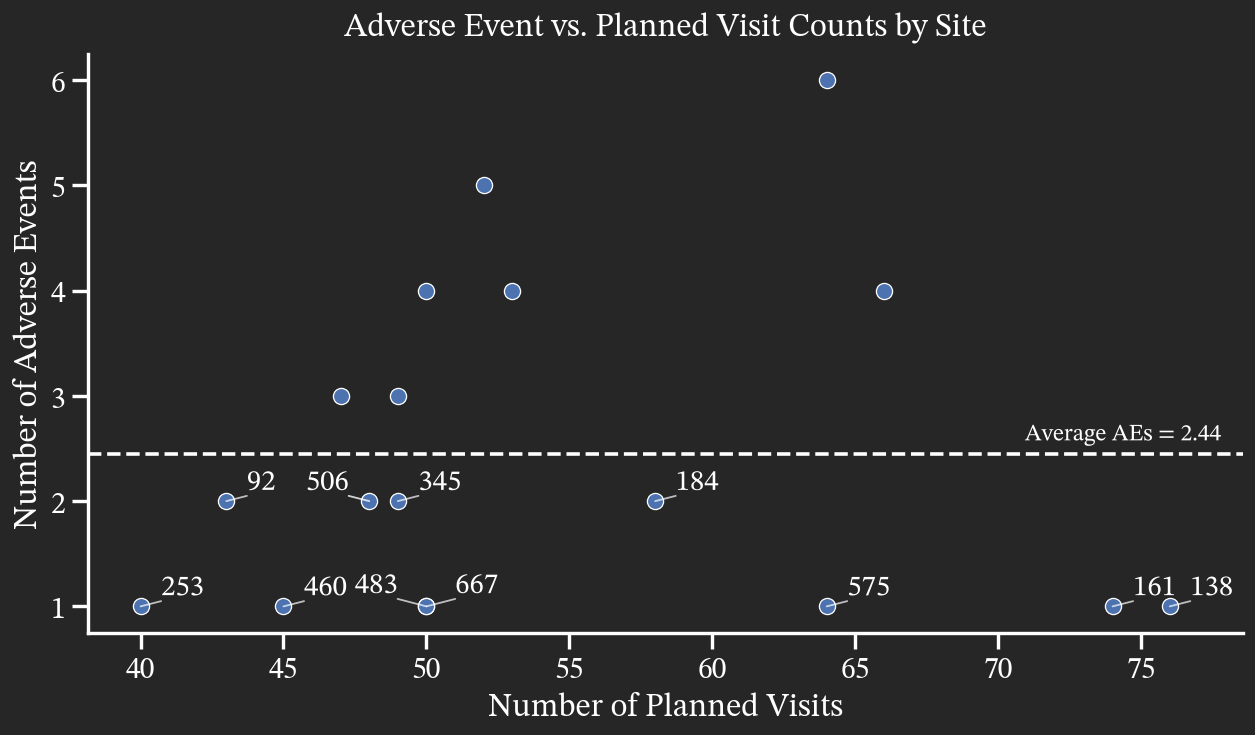

In [9]:
# Set background.
BG = "#262626"
sns.set_theme(context="talk", style="ticks")

# Try to use STIX Two Text; fall back if not.
from matplotlib import font_manager
if any("STIX Two Text" in f.name for f in font_manager.fontManager.ttflist):
    plt.rcParams["font.family"] = "STIX Two Text"
else:
    plt.rcParams["font.family"] = ["STIX Two Text", "STIXGeneral", "DejaVu Sans"]

plt.rcParams.update({
    "text.color": "white",
    "axes.labelcolor": "white",
    "axes.edgecolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "figure.facecolor": BG,
    "axes.facecolor": BG,
})

# Build plotting frame.
scatter_df = SV_per_site.merge(AE_per_site, on="Site", how="inner").copy()
scatter_df["PlannedVisits"] = pd.to_numeric(scatter_df["PlannedVisits"], errors="coerce")
scatter_df["AEs"] = pd.to_numeric(scatter_df["AEs"], errors="coerce")
avg_ae = float(scatter_df["AEs"].mean())
fig, ax = plt.subplots(figsize=(10, 6), dpi=130)

# Plot points.
sns.scatterplot(
    data=scatter_df,
    x="PlannedVisits", y="AEs",
    s=80, ax=ax
)

# Turn off grids.
ax.grid(False)
ax.grid(False, which='both')

# Average AE line + label
ax.axhline(avg_ae, linestyle="--", linewidth=2, color="white")
x_right = ax.get_xlim()[1] 
y_off_pts = 5
ax.annotate(
    f"Average AEs = {avg_ae:.2f}",
    xy=(x_right, avg_ae), xytext=(0, y_off_pts),
    textcoords="offset points",
    ha="right", va="bottom", fontsize=13, color="white",
    path_effects=[pe.withStroke(linewidth=2.0, foreground=BG)]
)

# Label only below-average points with collision-aware offsets + connectors.
below = scatter_df[scatter_df["AEs"] < avg_ae].copy()
x_span = max(scatter_df["PlannedVisits"].max() - scatter_df["PlannedVisits"].min(), 1.0)
y_span = max(scatter_df["AEs"].max() - scatter_df["AEs"].min(), 1.0)
LABEL_FONTSIZE = 16

# Force site 506 to the LEFT, always.
s506 = below[below["Site"].astype(str).str.strip() == "506"]
if len(s506):
    xv = float(s506["PlannedVisits"].iloc[0])
    yv = float(s506["AEs"].iloc[0])
    dx = -0.02 * x_span   # 8% of x-span to the LEFT
    dy =  0.01 * y_span   # lift a bit
    ax.plot([xv, xv + dx], [yv, yv + dy], color="white", alpha=0.8, linewidth=1.0, zorder=1)
    ax.text(
        xv + dx, yv + dy, "506",
        ha="right", va="bottom", fontsize=LABEL_FONTSIZE, color="white", zorder=2,
        clip_on=False, path_effects=[pe.withStroke(linewidth=2.5, foreground=BG)]
    )
    below = below[below["Site"].astype(str).str.strip() != "506"]

# Label remaining below-average sites.
FAN_X = 0.02
FAN_Y = 0.01

labels = []
for (xv, yv), grp in below.groupby(["PlannedVisits", "AEs"], dropna=False):
    n = len(grp)
    if n == 1:
        offs = [(FAN_X * x_span, FAN_Y * y_span, "left")]
    else:
        shifts = np.arange(n) - (n - 1) / 2.0
        offs = []
        for s in shifts:
            dx = np.sign(s) * (abs(s) + 0.9) * FAN_X * x_span
            dy = (1.25 + 0.35 * abs(s)) * FAN_Y * y_span
            ha = "left" if dx >= 0 else "right"
            offs.append((dx, dy, ha))
    for (site, (dx, dy, ha)) in zip(grp["Site"].astype(str), offs):
        labels.append({"x": float(xv), "y": float(yv), "dx": dx, "dy": dy, "ha": ha, "site": site})

# Repel for near collisions.
THRESH_X = 0.018 * x_span
THRESH_Y = 0.050 * y_span
BUMP_X   = 0.020 * x_span
BUMP_Y   = 0.035 * y_span
placed = []
for L in sorted(labels, key=lambda d: (d["y"], d["x"])):
    nx, ny = L["x"] + L["dx"], L["y"] + L["dy"]
    iter_guard = 0
    while any(abs(nx - px) < THRESH_X and abs(ny - py) < THRESH_Y for (px, py) in placed) and iter_guard < 25:
        L["dy"] += BUMP_Y
        L["dx"] += (BUMP_X if (iter_guard % 2 == 0) else -BUMP_X)
        nx, ny = L["x"] + L["dx"], L["y"] + L["dy"]
        iter_guard += 1

    placed.append((nx, ny))
    ax.plot([L["x"], nx], [L["y"], ny], color="white", alpha=0.7, linewidth=1.0, zorder=1)
    ha = "right" if (nx < L["x"]) else "left"
    ax.text(
        nx, ny, L["site"], ha=ha, va="bottom", fontsize=LABEL_FONTSIZE, color="white",
        clip_on=False, zorder=2, path_effects=[pe.withStroke(linewidth=2.4, foreground=BG)]
    )

# Title and label.
ax.set_title("Adverse Event vs. Planned Visit Counts by Site", color="white", pad=10)
ax.set_xlabel("Number of Planned Visits")
ax.set_ylabel("Number of Adverse Events")

# Show.
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

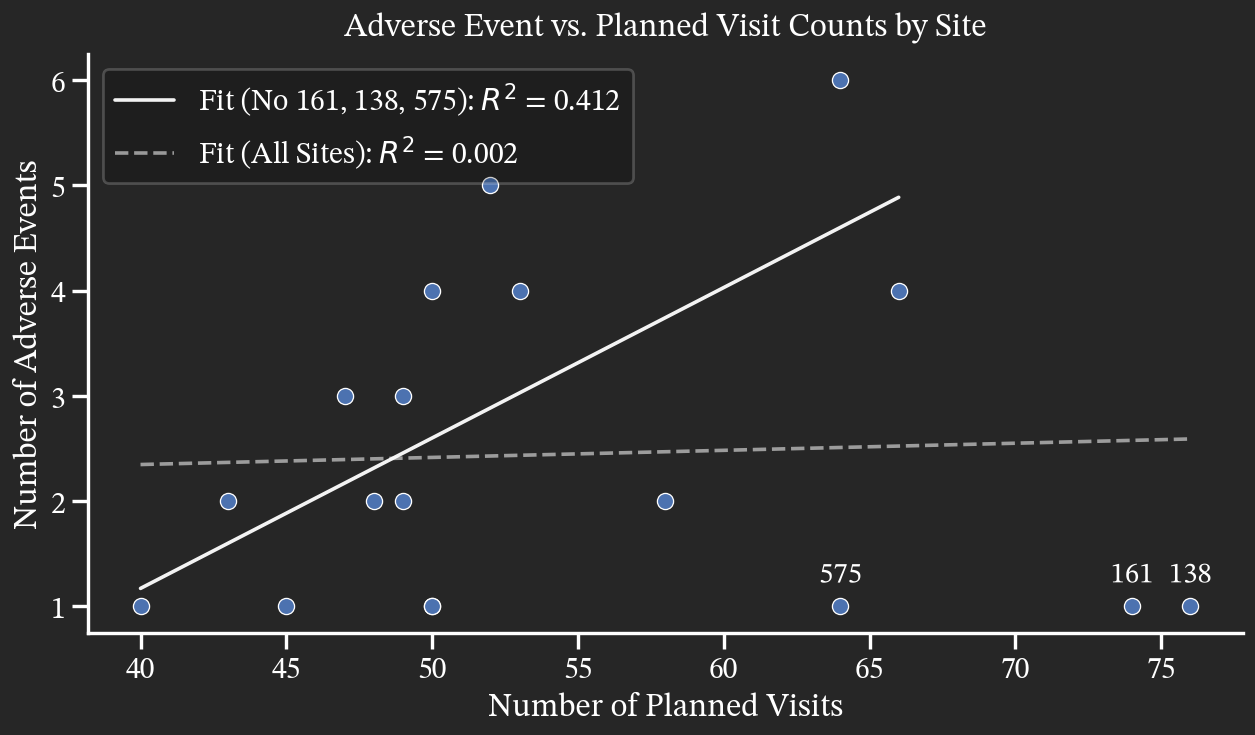

In [10]:
# Build plotting frame.
scatter_df = SV_per_site.merge(AE_per_site, on="Site", how="inner").copy()
scatter_df["PlannedVisits"] = pd.to_numeric(scatter_df["PlannedVisits"], errors="coerce")
scatter_df["AEs"] = pd.to_numeric(scatter_df["AEs"], errors="coerce")

fig, ax = plt.subplots(figsize=(10, 6), dpi=130)

# Plot points.
sns.scatterplot(
    data=scatter_df,
    x="PlannedVisits", y="AEs",
    s=80, ax=ax
)

# Turn grids off.
ax.grid(False); ax.grid(False, which="both")

# Regress linearly.
exclude_sites = {"575", "161", "138"}
fit_df = scatter_df[~scatter_df["Site"].astype(str).isin(exclude_sites)].copy()

# Fit excluding 3 sites.
sns.regplot(
    data=fit_df, x="PlannedVisits", y="AEs",
    scatter=False, ci=None, ax=ax,
    line_kws={"color": "white", "linewidth": 2, "alpha": 0.95, "linestyle": "-"}
)

# Fit including all sites.
sns.regplot(
    data=scatter_df, x="PlannedVisits", y="AEs",
    scatter=False, ci=None, ax=ax,
    line_kws={"color": "white", "linewidth": 2, "alpha": 0.55, "linestyle": "--"}
)

# Create legend.
def safe_r2(df):
    x = df["PlannedVisits"].to_numpy(dtype=float)
    y = df["AEs"].to_numpy(dtype=float)
    if x.size < 2 or np.allclose(x, x[0]):
        return float("nan")
    r = np.corrcoef(x, y)[0, 1]
    return float(r * r)

r2_excl = safe_r2(fit_df)
r2_incl = safe_r2(scatter_df)

# Add R^2 values.
from matplotlib.lines import Line2D
incl = Line2D([0], [0], color="white", lw=2, ls="--", alpha=0.55,
              label=fr"Fit (All Sites): $R^2$ = {r2_incl:.3f}")
excl = Line2D([0], [0], color="white", lw=2, ls="-",  alpha=0.95,
              label=fr"Fit (No 161, 138, 575): $R^2$ = {r2_excl:.3f}")
leg = ax.legend(handles=[excl, incl], loc="upper left", framealpha=0.2)
for t in leg.get_texts():
    t.set_color("white")
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_facecolor((0, 0, 0, 0))

# Label sites.
import matplotlib.patheffects as pe
lab_df = scatter_df[scatter_df["Site"].astype(str).isin(exclude_sites)].copy()
for _, r in lab_df.iterrows():
    ax.annotate(
        str(r["Site"]),
        xy=(r["PlannedVisits"], r["AEs"]), xytext=(0, 10),
        textcoords="offset points", ha="center", va="bottom",
        fontsize=16, color="white",
        path_effects=[pe.withStroke(linewidth=2.2, foreground=BG)]
    )

# Title and label.
ax.set_title("Adverse Event vs. Planned Visit Counts by Site", color="white", pad=10)
ax.set_xlabel("Number of Planned Visits")
ax.set_ylabel("Number of Adverse Events")

# Show.
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

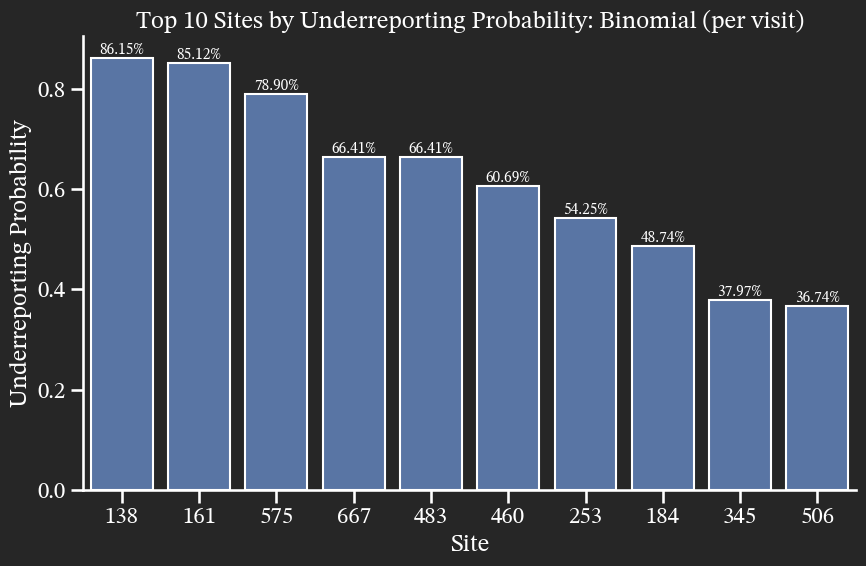

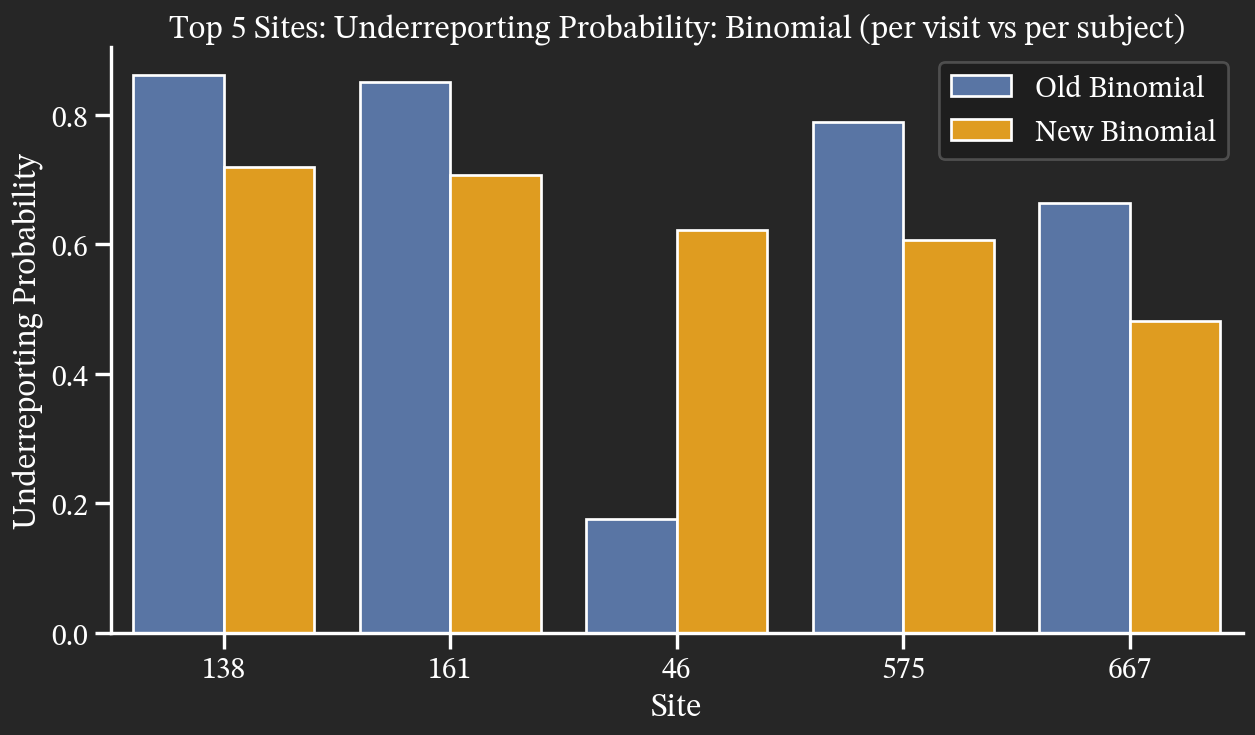

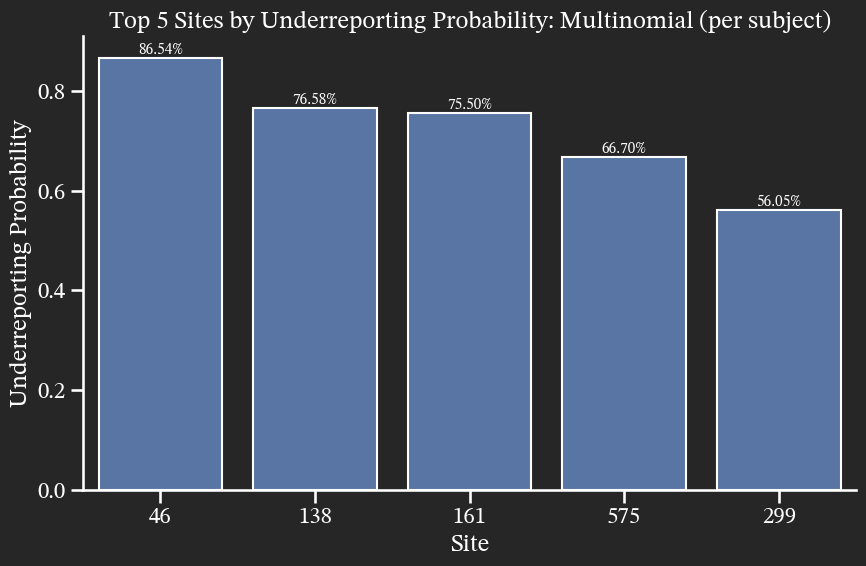

In [11]:
# Binomial, by visits.
bin_top5 = (
    AE_rate_per_visit
    .sort_values("ProbabilityUnderreporting", ascending=False)
    .head(10)
    .copy()
)
bin_top5["Site"] = bin_top5["Site"].astype("string")

fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(
    data=bin_top5,
    x="Site", y="ProbabilityUnderreporting",
    ax=ax
)
ax.set_title("Top 10 Sites by Underreporting Probability: Binomial (per visit)")
ax.set_xlabel("Site")
ax.set_ylabel("Underreporting Probability")
for p in ax.patches:
    h = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2, h,
        f"{h:.2%}",
        ha="center", va="bottom", fontsize=11
    )
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

# Binomial, per subject.
AE_rate_per_subject = AE_rate_per_subject.copy()
AE_rate_per_visit   = AE_rate_per_visit.copy()
AE_rate_per_subject["Site"] = pd.to_numeric(AE_rate_per_subject["Site"], errors="coerce").astype("Int64")
AE_rate_per_visit["Site"]   = pd.to_numeric(AE_rate_per_visit["Site"],   errors="coerce").astype("Int64")
subj_top5 = (
    AE_rate_per_subject
    .sort_values("ProbabilityUnderreporting", ascending=False)
    .head(5)
    .copy()
)
visit_lookup = (
    AE_rate_per_visit[["Site", "ProbabilityUnderreporting"]]
    .rename(columns={"ProbabilityUnderreporting": "Prob_Visit"})
)
comp = (
    subj_top5[["Site", "ProbabilityUnderreporting"]]
    .rename(columns={"ProbabilityUnderreporting": "Prob_Subject"})
    .merge(visit_lookup, on="Site", how="left")
)
comp["SiteLabel"] = comp["Site"].astype("string")
order = comp["SiteLabel"].tolist()
plot_df = comp.melt(
    id_vars="SiteLabel",
    value_vars=["Prob_Subject", "Prob_Visit"],
    var_name="Model",
    value_name="ProbabilityUnderreporting"
)
plot_df["Model"] = plot_df["Model"].map({
    "Prob_Subject": "New Binomial",
    "Prob_Visit":   "Old Binomial"
})
base_blue = sns.color_palette()[0]
fig, ax = plt.subplots(figsize=(10, 6), dpi=130)
sns.barplot(
    data=plot_df,
    x="SiteLabel", y="ProbabilityUnderreporting",
    hue="Model",
    order=order,
    hue_order=["Old Binomial", "New Binomial"],
    palette={
        "Old Binomial": base_blue,
        "New Binomial": "orange",
    },
    ax=ax
)
ax.set_title("Top 5 Sites: Underreporting Probability: Binomial (per visit vs per subject)")
ax.set_xlabel("Site")
ax.set_ylabel("Underreporting Probability")
leg = ax.legend(loc="upper right", framealpha=0.2, title=None)
for t in leg.get_texts(): t.set_color("white")
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_facecolor((0, 0, 0, 0))
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

# Multinomial
multi_top5 = (
    xs[["Site", "ProbabilityUnderreporting"]]
    .sort_values("ProbabilityUnderreporting", ascending=False)
    .head(5)
    .copy()
)
multi_top5["Site"] = multi_top5["Site"].astype("string")
fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(
    data=multi_top5,
    x="Site", y="ProbabilityUnderreporting",
    ax=ax
)
ax.set_title("Top 5 Sites by Underreporting Probability: Multinomial (per subject)")
ax.set_xlabel("Site")
ax.set_ylabel("Underreporting Probability")
for p in ax.patches:
    h = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2, h,
        f"{h:.2%}",
        ha="center", va="bottom", fontsize=11
    )
sns.despine(ax=ax)
plt.tight_layout()
plt.show()